 ## Welcome to dymoval's tutorial!
 
In this tutorial we show the main functionalities of *dymoval*.

Firstly, let's import some useful packages

In [1]:
import dymoval as dmv
import numpy as np
import matplotlib.pyplot as plt
import h5py
from copy import deepcopy
from itertools import product

Then, let's read the log data collected from experiments in the lab. 
We assume that data have been logged in hdf5 format and we use the h5py package to read it.
For more info check the h5py docs.

In [2]:
logs = h5py.File('./ElMotorLogs.h5', 'r')
logs.keys()

<KeysViewHDF5 ['signals']>

For this example, we assume that all the signals are logged in the group *signals*

In [3]:
logs["signals"].keys()

<KeysViewHDF5 ['V', 'dot_theta', 'ia', 'theta']>

We can extract the logged signals as it follows (see h5py docs for more info)

In [4]:
V = logs["signals/V"]
ia = logs["signals/ia"]
theta = logs["signals/theta"]
dot_theta = logs["signals/dot_theta"]

At this point we can cast the logs into *dymoval* `Signal`s. 

In [5]:
signal_list = []
for val in [V,ia,theta,dot_theta]:
    temp:dmv.Signal={
        "name" : val.attrs["name"].decode('utf-8'),
        "values" : val[:],
        "signal_unit" : val.attrs["unit"].decode('utf-8'),
        "sampling_period" : val.attrs["period"][0],
        "time_unit" : val.attrs["sampling_unit"].decode('utf-8'),
    }
    signal_list.append(deepcopy(temp))


... and we can take a look at them. 

(<Figure size 640x480 with 4 Axes>, <numpy.flatiter at 0x1f760164600>)

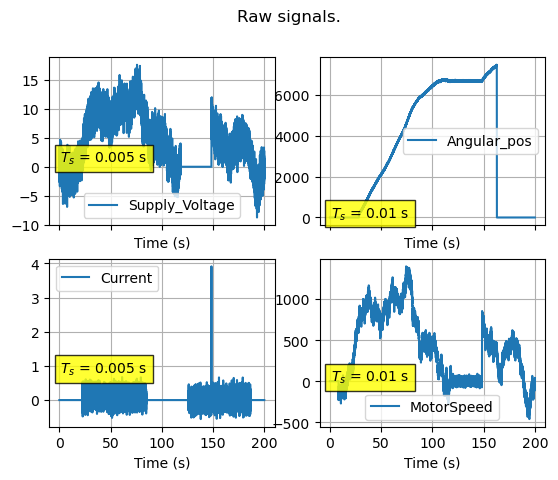

In [6]:
dmv.plot_signals(*signal_list)

Let's separate input and output...

In [7]:
signal_names = [s["name"] for s in signal_list]
u_names = signal_names[0]
y_names = signal_names[1:]
ds = dmv.Dataset(
    "ElMotor",
    signal_list,
    u_names,
    y_names,
    target_sampling_period=0.01,
    tin = 25.0,
    tout = 80.0,
)

In [9]:
ds.excluded_signals

[]

In [10]:
ds.sampling_period

0.01

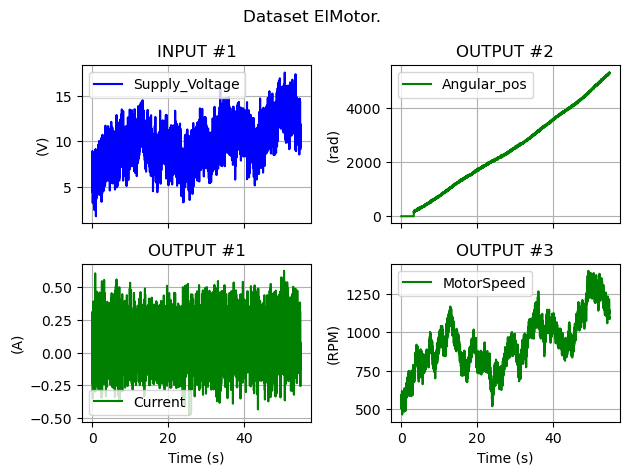

In [8]:
ds.plot()

(<numpy.flatiter at 0x1f76016a510>, <numpy.flatiter at 0x1f76016ba30>)

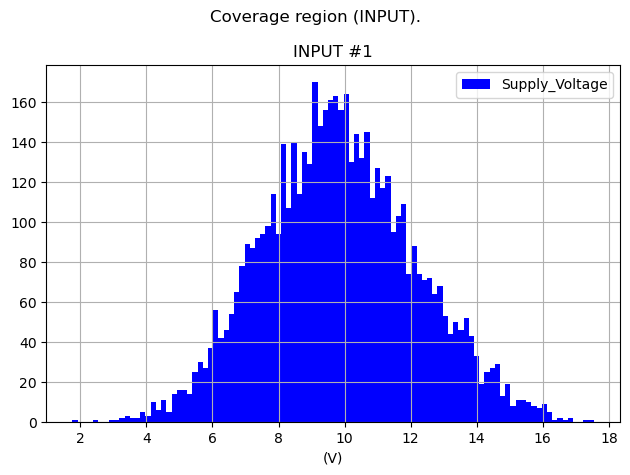

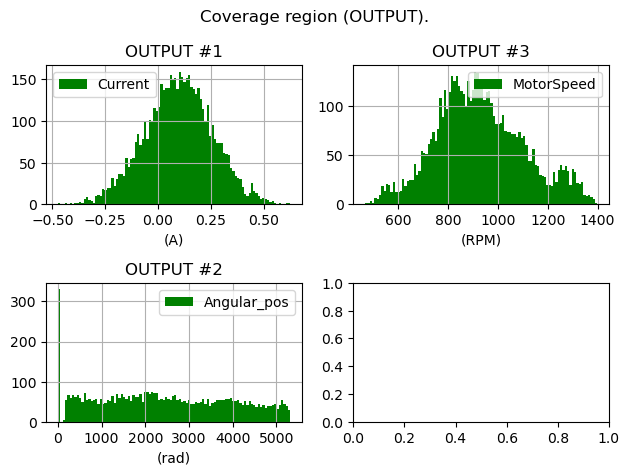

In [14]:
ds.plot_coverage()

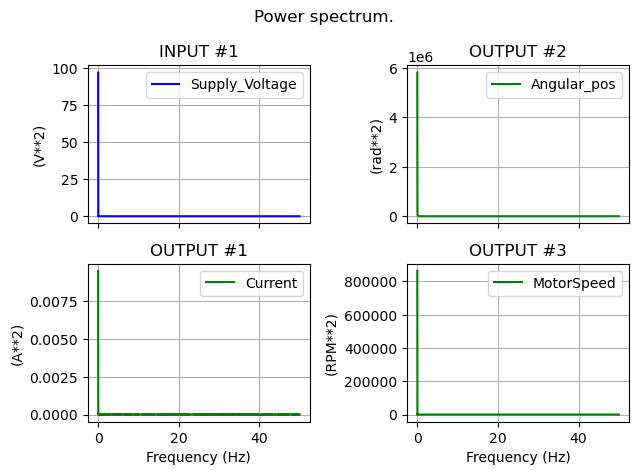

In [9]:
ds.plot_spectrum()

C:\VAS\github\dymoval\src\dymoval\dataset.py:1827: PerformanceWarning: indexing past lexsort depth may impact performance.
  u_filt = df_temp[("INPUT", u)].to_numpy()
C:\VAS\github\dymoval\src\dymoval\dataset.py:1834: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_temp.loc[:, ("INPUT", u)] = y_filt
C:\VAS\github\dymoval\src\dymoval\dataset.py:1844: PerformanceWarning: indexing past lexsort depth may impact performance.
  u_filt = df_temp[("OUTPUT", y)].to_numpy()
C:\VAS\github\dymoval\src\dymoval\dataset.py:1851: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_temp.loc[:, ("OUTPUT", y)] = y_filt


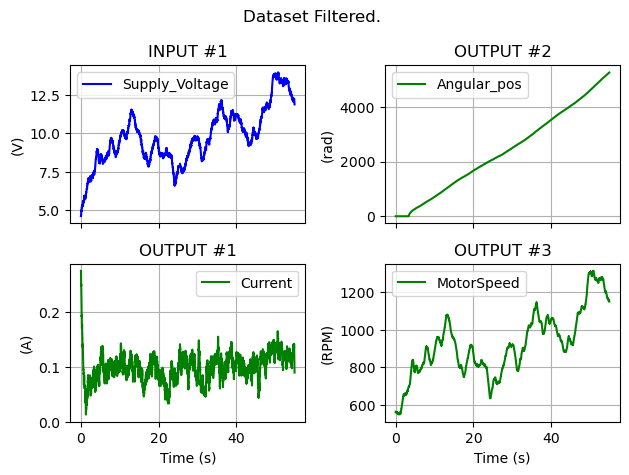

In [16]:
cutoff = 2.5  # [Hz]
signal_names = [s[1] for s in ds.signal_names()]
filter_bank = list(product(signal_names,[cutoff]))
ds_filt = ds.low_pass_filter(*filter_bank)
ds_filt.name = "Filtered"
ds_filt.plot()

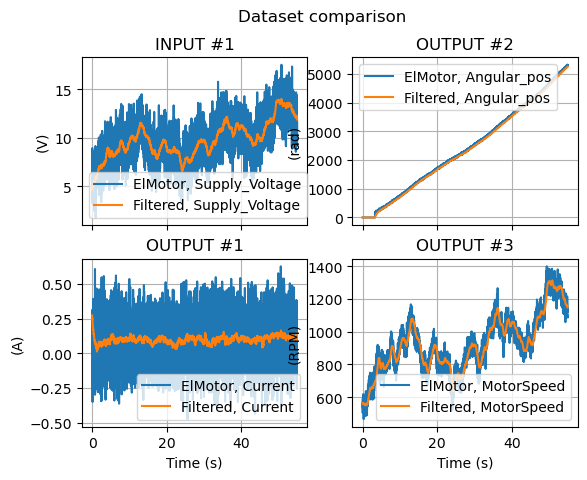

In [17]:
dmv.compare_datasets(ds,ds_filt)

In [29]:
ds.coverage[2]

names        units
Current      A           0.097438
Angular_pos  rad      2408.749179
MotorSpeed   RPM       929.300325
dtype: float64

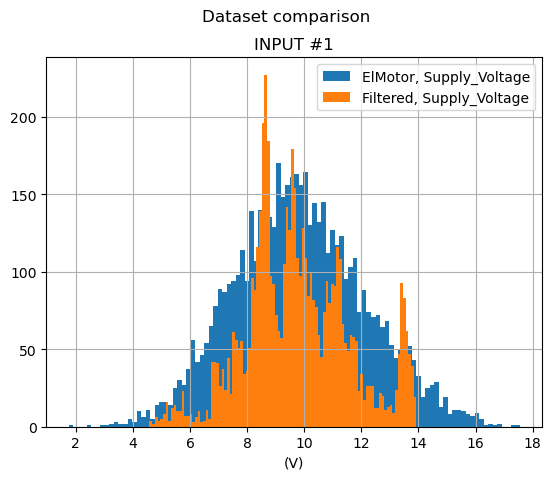

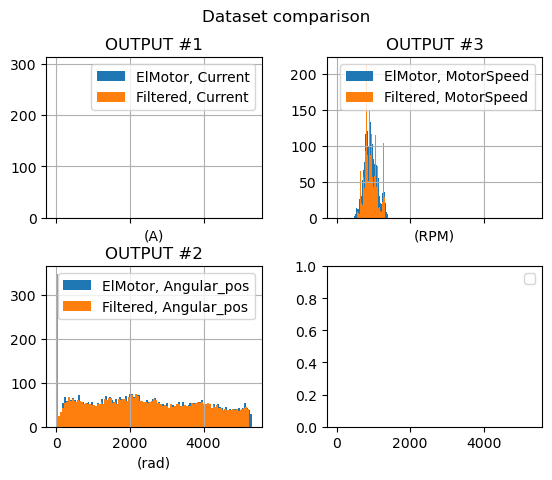

In [15]:
dmv.compare_datasets(ds,ds_filt,kind="coverage")